# Where is the Best Neighborhood in Seattle?

This is part 2 of a project I initially started as a means of finding a place to live. I ended up moving before finishing the project, but the data was interesting enough to motivate me to finish it. While the primary overall goal of this project is to determine the quality of life throughout Seattle, I have a few secondary goals for this part of the project:
<ul>
    <li>Find out how criminal activity has changed with time in Seattle
    <li>Find out how much each Seattle neighborhood has experienced criminal activity and code violations
    <li>Practice manipulating large data sets in efficient ways using Pandas and Numpy
</ul>

In this part, I use data from my previous look at code violations in Seattle (in the time domain) as well as criminal activity data provided by [data.seattle.gov](data.seattle.gov). I will also use time series analysis methods I first encountered in [Jake Vanderplas' Blog](https://jakevdp.github.io/blog/2015/07/23/learning-seattles-work-habits-from-bicycle-counts/), and choropleth creation code I encountered on [Beneath Data](http://beneathdata.com/how-to/visualizing-my-location-history/)

## The Data

I use two data sets in part 2. The first contains 608291 logged [criminal cases](https://data.seattle.gov/Public-Safety/Seattle-Police-Department-Police-Report-Incident/i6vm-ucwh) around Seattle 1989-2016. This data was accessed 04/04/2016 but only goes up to 02/27/2016. The cases range from petty theft to homicide and, if a case has more than one offense, it is logged multiple times. These are offenses that were called in by someone, responded to, and officially entered into the police records. Among other information, this set lists offense type, date, and location.
The second data set is the code violation data from part 1 that I can use figure out which neighborhoods experience the most/least code violation cases.

## The Analysis

Using the same methods as in the previous part, I will use Pandas, Matplotlib, and Numpy for most all of the analysis. Using timestamps from the crime data, I can make a timeseries that make certain types of analysis easier.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('ggplot')

crimes = pd.read_csv('crimes.csv', index_col='Date Reported', parse_dates=True)

Here are the headers for the 'crimes' dataset, and an example of what it looks like.

In [2]:
crimes.head(1)

,RMS CDW ID,General Offense Number,Offense Code,Offense Code Extension,Offense Type,Summary Offense Code,Summarized Offense Description,Occurred Date or Date Range Start,Occurred Date Range End,Hundred Block Location,District/Sector,Zone/Beat,Census Tract 2000,Longitude,Latitude,Location,Month,Year
Date Reported,,,,,,,,,,,,,,,,,,
2016-02-27 22:26:00,648460,201670728,3542,1,NARC-POSSESS-METH,3500,NARCOTICS,02/27/2016 10:26:00 PM,NaN,5 AV S / S MAIN ST,K,K3,9200.1012,-122.327667,47.600033,"(47.600032806, -122.327667236)",2,2016


Here is a look at amounts of the different types of offenses listed in this dataset. The offense descriptions are sometimes in all caps or with the beginning letters capitalized, so I can combine these with Pandas to avoid having separate listings.

In [3]:
crimes['Summarized Offense Description'].str.capitalize().value_counts()

Car prowl                           111416
Other property                       72950
Burglary                             64346
Property damage                      44951
Vehicle theft                        44090
Fraud                                34303
Assault                              33920
Warrant arrest                       30315
Threats                              20970
Disturbance                          19898
Stolen property                      19675
Shoplifting                          19479
Narcotics                            14616
Robbery                              13385
Bike theft                            9978
Trespass                              8545
Burglary-secure parking-res           5932
Traffic                               4010
Weapon                                3266
Lost property                         3046
Prostitution                          2951
Mail theft                            2768
Dispute                               2757
Pickpocket 

Now for some cleaning up. Turns out that there are a lot of entries that have only part of the information filled in, having either missing entries or have filler entries such as lat/longitude being set to zero. There is scarce, incomplete data stretching back to 1989, but 2008 is where the entries become much more regular. There are also offenses listed as '[inc - case dc use only]', which I can only assume are redacted reports that I cannot use.

Last, I strip away headers that I don't think are useful, e.g. we don't need 'location' if we have 'latitude' and 'longitude'. Really, the things I care about are the types of offenses and also where and when they happened.

In [4]:
crimes = crimes[['Summarized Offense Description','District/Sector', 'Zone/Beat', 'Latitude', 'Longitude']].dropna()
crimes = crimes[(crimes['Latitude'] != 0.0) & (crimes['Longitude'] != 0.0)]
crimes = crimes[:'2008-01-01']
crimes = crimes[crimes['Summarized Offense Description'].str.capitalize() != '[inc - case dc use only]']
len(crimes)

602893

So after some cleaning up, there are now 602893 fine points of data.

Now, the two main things I want to do with this data are: 1) Figure out how crime has changed with time and 2) Figure out how crime counts are distributed throughout the city. However, there is a big spread in the kinds of offenses that are considered criminal activity. Something like fireworks does not bother me as much as homicide being nearby. 
My solution to this is to split up the criminal cases into "very bad to have nearby" and "not quite as bad to have nearby", which I call severe and mild. That is not to say I would want to live around the mild offenses, just that these severe offenses are very easy to point at and say "this makes a neighborhood unsafe."

In [5]:
severeoffense = np.array(['Assault', 'Threats', 'Narcotics', 'Weapon', 'Burglary', 'Homicide', 'Robbery', 'Car prowl', 'Pornography`'])
crimes['Severe'] = np.in1d(crimes['Summarized Offense Description'].str.capitalize(), severeoffense)

So here is a first look at how crime counts have changed in time since 2008 for both kinds of crimes

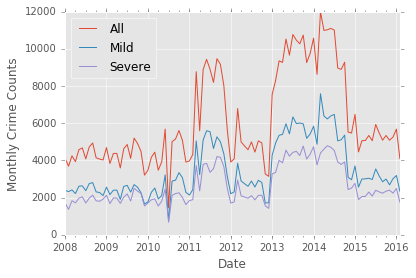

In [6]:
crime_counts = pd.DataFrame({'Severe': pd.Series(crimes[crimes['Severe'] == True].index.value_counts().resample('M', how='sum')),
                                    'Mild': pd.Series(crimes[crimes['Severe'] == False].index.value_counts().resample('M', how='sum')),
                                    'All': pd.Series(crimes.index.value_counts().resample('M', how='sum'))})
crime_counts = crime_counts.fillna(0)
crime_counts.plot()
plt.xlabel('Date')
plt.ylabel('Monthly Crime Counts')

There are blocks of time within 2011 and 2013-2015 where the number of all reported crimes, mild and severe, increases by something like a factor of 2. This drops off before 2012 and once more before 2015, after which it returns to numbers slightly higher than pre-2011.

In [7]:
crime_counts[:'2011-01-01'].describe()

,All,Mild,Severe
count,36.000000,36.000000,36.000000
mean,4300.888889,2402.416667,1898.472222
std,766.513620,466.443956,333.680042
min,1450.000000,773.000000,677.000000
25%,3931.750000,2249.250000,1715.250000
50%,4309.500000,2396.500000,1922.000000
75%,4755.250000,2636.750000,2121.000000
max,5685.000000,3344.000000,2502.000000


In [8]:
crime_counts['2013-01-01':'2015-01-01'].describe()

,All,Mild,Severe
count,24.000000,24.000000,24.000000
mean,9555.583333,5482.875000,4072.708333
std,1632.982039,1024.242215,648.156146
min,5472.000000,2963.000000,2435.000000
25%,8946.250000,5094.000000,3850.250000
50%,9704.500000,5423.500000,4246.000000
75%,10745.250000,6063.750000,4539.250000
max,11986.000000,7584.000000,4791.000000


In fact, the mean number of reported crimes between 2013-2015 is very close to 2x higher than pre-2011. The minimum reported each month is much higher and the spread is 2x larger between 2011-2015. What is this heightening of reported criminal activity?

Using methods from part 1, I can isolate contributions from seasonal variations:

In [9]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    diff = date - pd.datetime(2000, 12, 21)
    day = diff.total_seconds() / 24. / 3600
    day %= 365.25
    m = 1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(day * np.pi / 182.625))
    m = max(0, min(m, 2))
    return 24. * np.degrees(np.arccos(1 - m)) / 180.

In [10]:
crime_counts['Daylight Hours'] = pd.Series(crime_counts.index.map(hours_of_daylight), index=crime_counts.index)

In [11]:
from sklearn.linear_model import LinearRegression

X = crime_counts['Daylight Hours'][:,np.newaxis]
y1 = crime_counts['Severe'][:,np.newaxis]
y2 = crime_counts['Mild'][:,np.newaxis]
fit1 = LinearRegression().fit(X,y1)
fit2 = LinearRegression().fit(X,y2)

crime_counts['Trend1S'] = fit1.predict(X)
crime_counts['Trend1M'] = fit2.predict(X)
crime_counts['Detrended1S'] = crime_counts['Severe'] - crime_counts['Trend1S'] + crime_counts['Trend1S'].mean()
crime_counts['Detrended1M'] = crime_counts['Mild'] - crime_counts['Trend1M'] + crime_counts['Trend1M'].mean()

So here is what it looks like without seasonal variations. It does not really make much difference.

Detrended1S    1032.504711
Severe         1040.611456
Detrended1M    1450.833667
Mild           1478.136103
dtype: float64

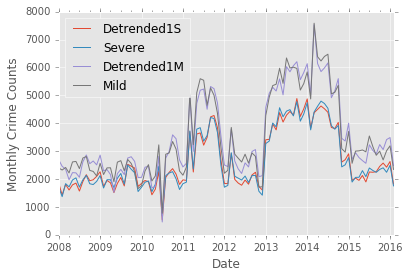

In [12]:
crime_counts[['Detrended1S','Severe','Detrended1M','Mild']].plot()
plt.xlabel('Date')
plt.ylabel('Monthly Crime Counts')
crime_counts[['Detrended1S','Severe','Detrended1M','Mild']].std()

The truth is that, even after a lot of searching, I cannot actually find anything that properly explains why this big jump in reported cases happens. I can take a look at the top 5 kinds of offenses to see if something is skewing the results...

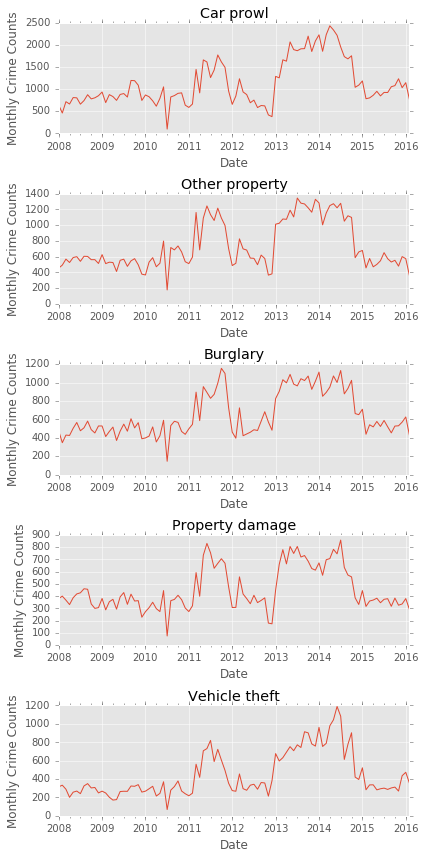

In [13]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(6,12))

descriptions = crimes['Summarized Offense Description'].str.capitalize()
offenses = [descriptions.value_counts().index[i] for i in range(5)]

for i in range(5):
    descriptions[descriptions == offenses[i]].index.value_counts().resample('M', how='sum').plot(ax=axes[i])
    axes[i].set_title(str(offenses[i]))
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Monthly Crime Counts')
fig.tight_layout()

But they all have roughly the same anomaly! I can split it up by district...

In [14]:
dist = crimes['District/Sector']
distN = crimes[(dist == 'B') | (dist == 'N') | (dist == 'L') | (dist == 'J') | (dist == 'U')]
distS = crimes[(dist == 'O') | (dist == 'R') | (dist == 'S')]
distE = crimes[(dist == 'E') | (dist == 'C') | (dist == 'G')]
distW = crimes[(dist == 'Q') | (dist == 'D') | (dist == 'M') | (dist == 'K')]
distSW = crimes[(dist == 'W') | (dist == 'F')]

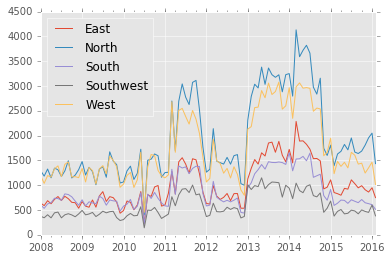

In [15]:
dist_tot = pd.DataFrame({'North': distN.index.value_counts(), 'South': distS.index.value_counts(),
                         'East': distE.index.value_counts(), 'West': distW.index.value_counts(),
                         'Southwest': distSW.index.value_counts()})

dist_tot.resample('M', how='sum').plot()

And again, this does not really show anything past this being a city-wide jump in reporting of all kinds of crimes. This could be some kind of internal policy change on general policing and reporting, or it could be a change in how much data was actually put online. Frankly, I have no idea!

Next, I look at the locational information contained in both the crime and code violation data sets through the use of neat maps called choropleths. They give a visual representation of how the counts are distributed throughout each neighborhood of Seattle. Big thanks to Tyler Hartley for coding exactly what I was looking for (http://beneathdata.com/how-to/visualizing-my-location-history/). His writeups are great, I highly recommend checking his stuff out. Most of the code from here on out is taken and modified from the above link.

First I read in the old code violations data and use only data from 2008-present to match the crime data.

In [16]:
violations = pd.read_csv('violations.csv', header=0, index_col='Date Case Created', parse_dates=True)
violations = violations[:'2008-01-01']

The code for creating the choropleth map is too long to have here, but it can be found in its original form on [Tyler Hartley's website](http://beneathdata.com/how-to/visualizing-my-location-history/), or in its module form on my [Github](https://gist.github.com/RaySSharma/5077ad8e2d8ea442b085923d5b2133d4).

In [17]:
import choropleth as ch
severe = crimes['Severe'] == True
mild = crimes['Severe'] == False

I want 4 choropleth maps: one for all code violations, one for all crime reports, then two for mild&severe crimes only. All the module needs is the shapefile, input data, desired figure size, and labels for titles and output image!

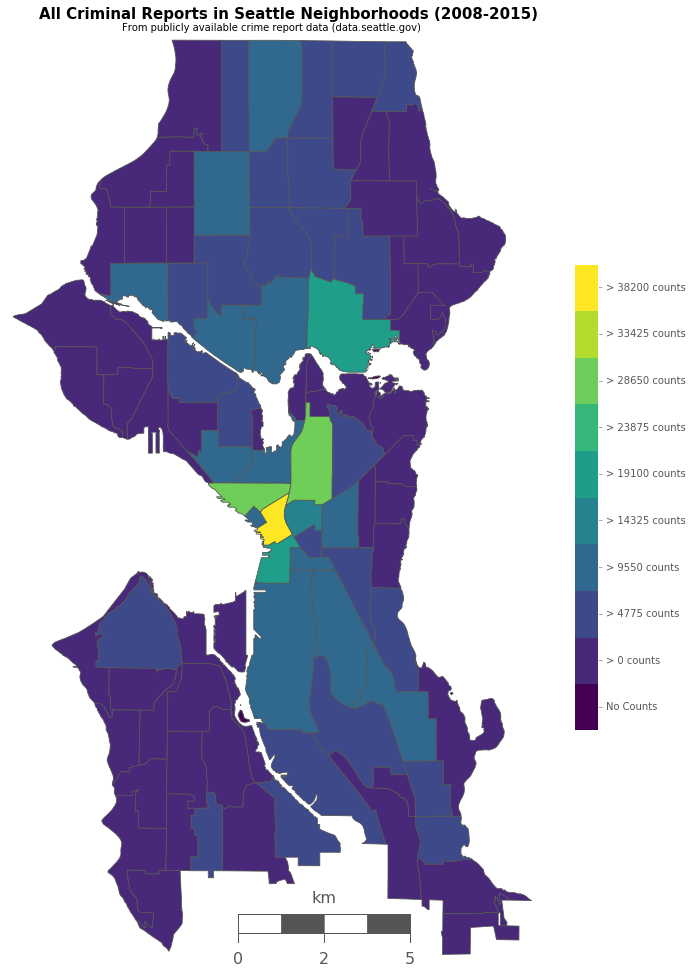

In [18]:
shapefilename = 'Neighborhoods/WGS84/Neighborhoods'
figwidth = 14
title = 'From publicly available crime report data (data.seattle.gov)'
suptitle = 'All Criminal Reports in Seattle Neighborhoods (2008-2015)'
savename = 'allcrime.png'
cmap = plt.get_cmap('viridis')
count1, name1, point_name1 = ch.choropleth(shapefilename, cmap, crimes['Latitude'], crimes['Longitude'], title, suptitle, savename, figwidth)

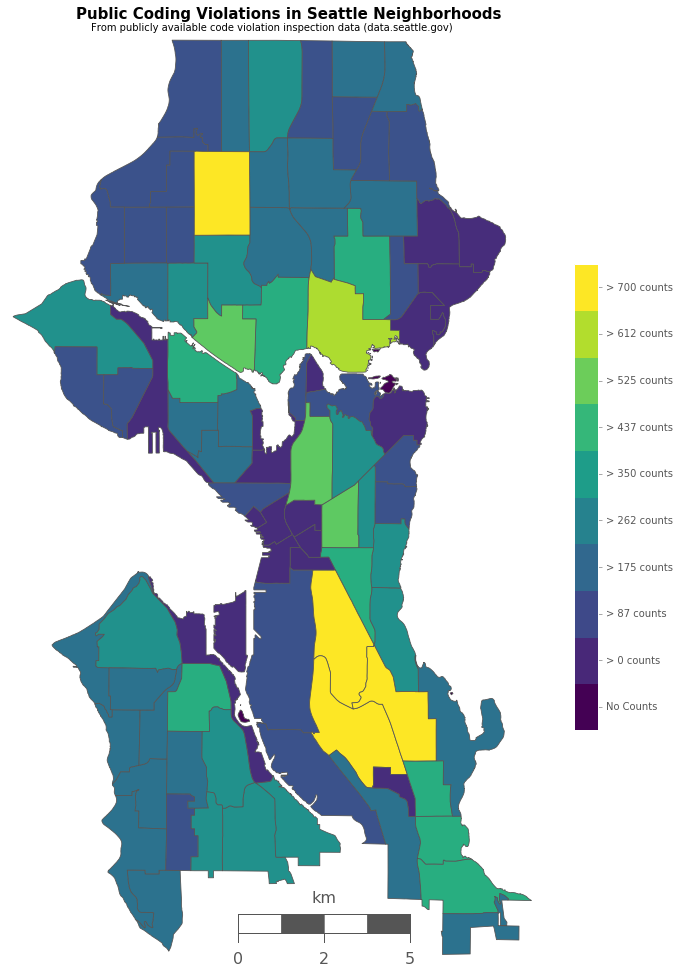

In [19]:
shapefilename = 'Neighborhoods/WGS84/Neighborhoods'
figwidth = 14
title = 'From publicly available code violation inspection data (data.seattle.gov)'
suptitle = 'Public Coding Violations in Seattle Neighborhoods'
savename = 'allviolations.png'
cmap = plt.get_cmap('viridis')
count2, name2, point_name2 = ch.choropleth(shapefilename, cmap, violations['Latitude'], violations['Longitude'], title, suptitle, savename, figwidth)

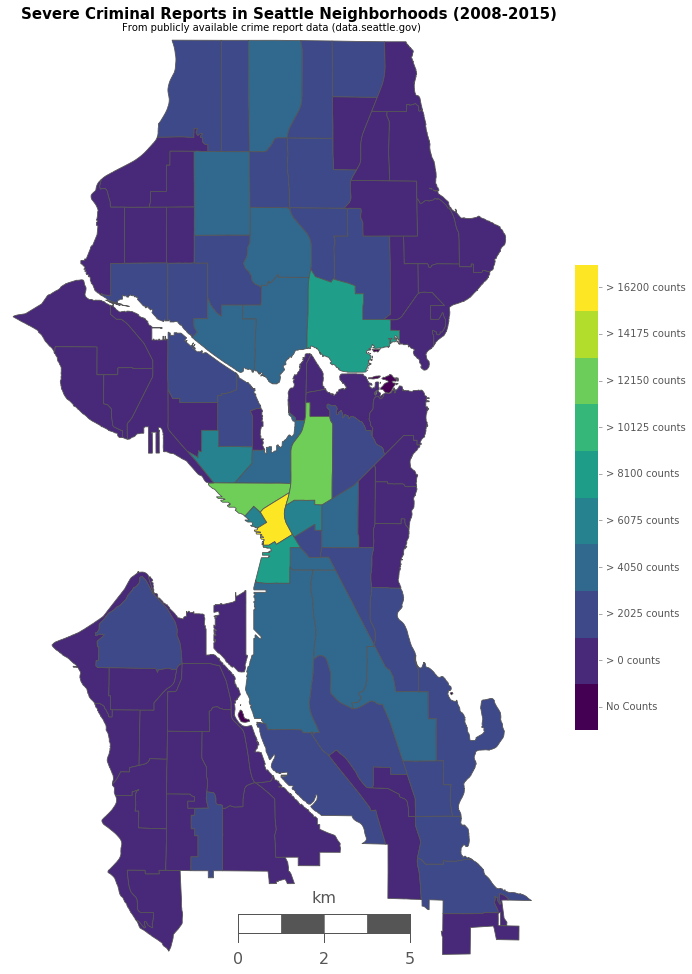

In [20]:
shapefilename = 'Neighborhoods/WGS84/Neighborhoods'
figwidth = 14
title = 'From publicly available crime report data (data.seattle.gov)'
suptitle = 'Severe Criminal Reports in Seattle Neighborhoods (2008-2015)'
savename = 'severecrime.png'
cmap = plt.get_cmap('viridis')
count3, name3, point_name3 = ch.choropleth(shapefilename, cmap, crimes[severe]['Latitude'], crimes[severe]['Longitude'], title, suptitle, savename, figwidth)

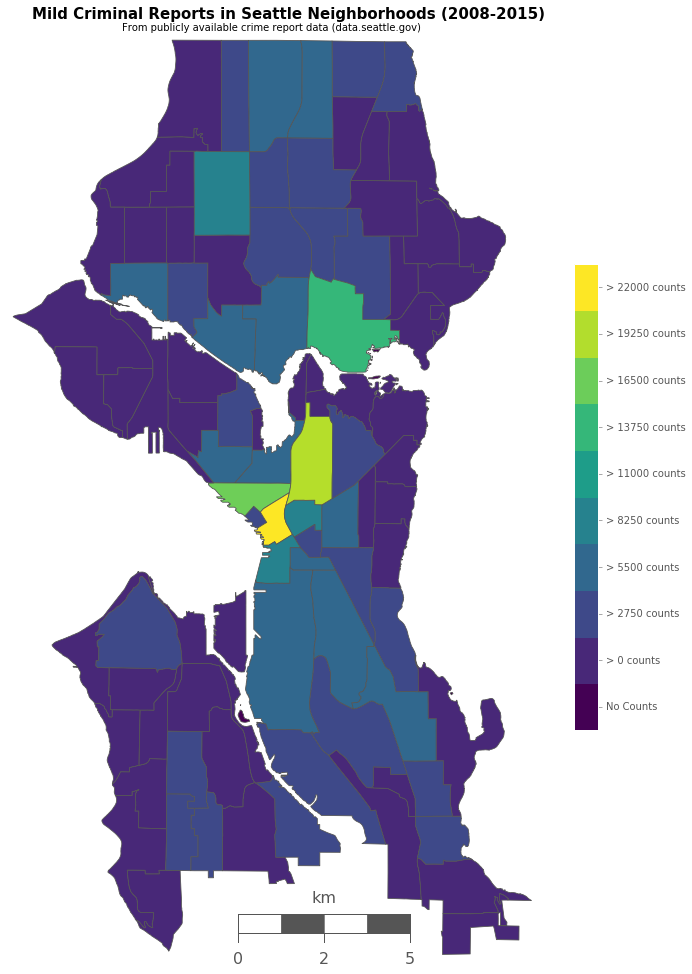

In [21]:
shapefilename = 'Neighborhoods/WGS84/Neighborhoods'
figwidth = 14
title = 'From publicly available crime report data (data.seattle.gov)'
suptitle = 'Mild Criminal Reports in Seattle Neighborhoods (2008-2015)'
savename = 'mildcrime.png'
cmap = plt.get_cmap('viridis')
count4, name4, point_name4 = ch.choropleth(shapefilename, cmap, crimes[mild]['Latitude'], crimes[mild]['Longitude'], title, suptitle, savename, figwidth)

From the looks of it, southwest, northeast, and northwest Seattle do not see too much criminal activity. Northeast and Downtown Seattle do not see too many coding violations. Severe and mild crimes tend to happen in roughly the same areas and so the maps look very similar.
The Belltown/Central Business District/Broadway area looks like it gets the brunt of criminal offenses.
Greenwood and parts of south Seattle look like, by far, the biggest numbers of code violations.

There are a few ways to decide exactly which neighborhoods are the best/worst. I can look at which neighborhoods have the highest relative numbers of both code violations and crime activity (severe and/or mild). I can also look at which neighborhoods are on the rise for crime activity.

First I clean the patches up since some neighborhoods are not given an official name but are labelled as 'OOO' so I can't say which is which. Additionally, some districts have 0 counts of anything, and so these do not matter anyway. 

In [251]:
def norm(X):
    return (X-X.min()) / (X.max() - X.min())

df = pd.DataFrame({'Names': name1,
                  'AllCrimes': count1,
                  'Violations': count2,
                  'SevereCrimes': count3,
                  'MildCrimes': count4})
df = df[df['AllCrimes'] > 0.]
df = df[df['Names'] != 'OOO']

I can normalize crimes and codes separately then add together to find the most/least influenced neighborhoods.

In [252]:
df['NormalAll'] = norm(df['AllCrimes']) + norm(df['Violations'])
df = df.sort_values('NormalAll', ascending=False)
df.index = range(1, len(df)+1)
df

,AllCrimes,MildCrimes,Names,SevereCrimes,Violations,NormalAll
1,32852,20559,Broadway,12293,506,1.580174
2,23598,14071,University District,9527,594,1.463823
3,13857,8640,Greenwood,5217,688,1.343312
4,10912,6002,Columbia City,4910,700,1.283321
5,11998,7010,North Beacon Hill,4988,665,1.261577
6,7119,3812,Mid-Beacon Hill,3307,639,1.096364
7,38249,22006,Central Business District,16243,59,1.080344
8,30200,17004,Belltown,13196,139,0.984106
9,11513,6407,Fremont,5106,452,0.943267
10,10251,5854,Minor,4397,438,0.890095


Here are a few points of interest:
<ul>
<li>Broadway is the worst neighborhood according to this method, followed by University District, Greenwood, and Columbia City in south Seattle.</li>
<li>At a first glance it is a surprise the Central Business District isn't higher up, but it has low numbers of code violations probably due to its small size and lack of residential zoning. The Central Business District does have the highest amount of crime activity for such a tiny neighborhood.</li>
<li>Harbor Island experiences the fewest crimes/violations, which isn't a surprise because of how little there is there. Industrial District being 2nd best is very surprising considering how close it is to the stadiums/SODO. Sand Point being 3rd best is not surprising to me at all, however, because of how fancy and out of the way that area is.</li>
</ul>

I am glad to see that my current neighborhood, Cedar Park, is 36th place -- much better than my previous neighborhood of University District!

The last thing I do is look at how criminal activity has changed in the past years in a very broad sense.
First, I can clean the array that contains the name of the district where every offense took place and apply it to the original crimes dataframe

In [253]:
crimes_district = []
for i in point_name1:
    try:
        crimes_district.append(i[0])
    except:
        crimes_district.append('None')
crimes['District'] = crimes_district

Next I can straight-line-fit the crime counts for each district against time, then take the slope to be a very rough overall change in crime activity over the past 8 years. 

In [283]:
district_gradient = []
for i in df['Names']:
    district_counts = crimes[crimes['District'] == i].index.value_counts()
    district_gradient.append(np.polyfit(norm(district_counts.index.astype(np.int64)), district_counts, 1)[0])

So after all is said and done, here are the final stats for each district sorted by changing crime activity.

In [284]:
df['CrimeChange'] = district_gradient
df.sort_values('CrimeChange', ascending=False)

,AllCrimes,MildCrimes,Names,SevereCrimes,Violations,NormalAll,CrimeChange
6,7119,3812,Mid-Beacon Hill,3307,639,1.096364,0.677626
64,2293,1210,Rainier View,1083,186,0.319915,0.643201
15,6573,3798,Brighton,2775,385,0.717631,0.636112
14,4461,2244,Rainier Beach,2217,424,0.718216,0.626076
88,834,419,Portage Bay,415,72,0.118107,0.618716
13,8446,4976,Dunlap,3470,366,0.739475,0.615970
83,2790,1152,Westlake,1638,43,0.127780,0.609827
51,3305,1964,South Beacon Hill,1341,218,0.392357,0.609758
74,3906,2104,Eastlake,1802,114,0.258903,0.607090
85,3248,1910,Holly Park,1338,32,0.124005,0.592340


Here are a few points of interest:
<ul>
    <li>Mid-Beacon Hill and Rainier View are the highest crime change neighborhoods.</li>
    <li>None of these are top-5 crime activity neighborhoods, although Mid-Beacon Hill is close at 6th place. </li>
    <li>None of the crime changes are negative. This is probably due to the anomalies in 2011/2013/2014 artificially inflating the line fit.</li>
    <li>Harbor Island and Sand Point, which were already near last place for crime counts, have the lowest crime change.</li>
</ul>

##  Conclusion

Using primarily Numpy, Pandas, scikit-learn, and Matplotlib, I take a closer look at criminal offenses reported to the Seattle Police Department and code violations reported to the city. There is a very clear distribution of criminal offenses and code violations throughout Seattle with hot spots in urban areas like Broadway, University District, and Greenwood, and cold spots in upscale residential areas like Sand Point, Portage Bay, and Windermere. However, these hot spots are also changing in time, with criminal offenses on the rise in areas such as Broadway and Green Lake, while these offenses are on the decline in others such as Belltown, Central Business District, and University District.